In [1]:
import sys

sys.path.insert(0, "/Users/JonathanHeitz/git/dementia/src/")

import matplotlib.pyplot as plt
import os
from sklearn import metrics as sk_metrics
import json
import numpy as np
import pandas as pd
import re, glob
from collections import defaultdict
from IPython.display import Image, display
import matplotlib.image as mpimg
from config.config import Config
from scipy import stats


In [2]:
# Evaluation metric

MAIN_METRIC = 'auroc'
#MAIN_METRIC = 'accuracy'
#MAIN_METRIC = 'precision'
#MAIN_METRIC = 'sensitivity'
#MAIN_METRIC = 'f1_score'

In [3]:

# load directories from results dir that contain the results we're interested in
results_base_dir = [
    "/Volumes/methlab/Students/Jonathan/results/runs/2024_kw34/20240821_0753_5ff6_feature_sets_cv",
    #"/Volumes/methlab/Students/Jonathan/results/runs/2024_kw34/20240821_0753_5ff6_feature_sets_traintest",  # train on train, test on test split of ADReSS, not used in final publication
    "/Volumes/methlab/Students/Jonathan/results/runs/2024_kw34/20240821_1329_4b70_feature_sets_cv",
    #"/Volumes/methlab/Students/Jonathan/results/runs/2024_kw34/20240821_1329_4b70_feature_sets_traintest",  # train on train, test on test split of ADReSS, not used in final publication
    "/Volumes/methlab/Students/Jonathan/results/runs/2024_kw34/20240819_0720_af88_results_for_paper_gpt_finetuned",
    "/Volumes/methlab/Students/Jonathan/results/runs/2024_kw34/20240821_1547_0684_feature_sets_cv",

]

results_dirs = [os.path.join(base) for base in results_base_dir if os.path.exists(os.path.join(base, "metrics.txt"))] +\
               [os.path.join(parent, dir) for base in results_base_dir for parent, dirs, _ in os.walk(os.path.join(base)) for dir in dirs if os.path.exists(os.path.join(parent, dir, "metrics.txt"))]

labels = defaultdict(lambda: [])
predictions = defaultdict(lambda: [])
dirs = defaultdict(lambda: [])
#print(results_dirs)
for d in results_dirs:
    # prepare data for results analysis
    # go through all results dirs, extract relevant information from e.g. config file, and condense them in parameter_string, which identifies a unique set of settings
    basename = os.path.basename(d)
    yaml_file = [f for f in os.listdir(d) if f.endswith(".yaml")][0]
    config = Config.from_yaml(os.path.join(d, yaml_file))
    
    # Either 'PAR segmentation' should be there (to remove interviewer speech), or it should be a manual transcript
    assert 'PAR segmentation' in config.preprocessors or config.data == 'ADReSS_manual_transcripts'
    relevant_preprocessors = [p for p in config.preprocessors if p != 'PAR segmentation']  
    
    preprocessors = "+".join(relevant_preprocessors)
    preprocessors = preprocessors.replace("Linguistic Features", "LinguF").replace("ASR google_speech", "Google").replace("ASR whisper", "Whisper")

    data = config.data
    data = data.replace("ADReSS_audio", "ADR").replace("ADReSS_with_PITT_audio", "ADR_PITT").replace("ADReSS_manual_transcripts", "manual")
    model = config.model.replace("RandomForest", "RF")
    
    try:
        gpt_model = config.config_gpt.model.replace("gpt-4o-mini-2024-07-18", " gpt-4o")
    except:
        try:
            gpt_model = config.config_linguistic_features.gpt_model.replace("gpt-4o-mini-2024-07-18", " gpt-4o")
        except:
            gpt_model = ""


    try: 
        feature_groups = config.config_linguistic_features.feature_groups
        if 'gpt_features' in feature_groups:
            idx = feature_groups.index("gpt_features")
            try:
                gpt_feature_version = config.config_linguistic_features.gpt_feature_version
            except:
                gpt_feature_version = ""
            feature_groups[idx] = f"gpt_features{gpt_feature_version}"
        feature_groups = [f.replace("literature_features", 'lit').replace("gpt_features", "gpt") for f in feature_groups]
        feature_groups = "&".join(feature_groups)
    except:
        feature_groups = "all"
        

    try:
        chat_parser_version = config.chat_parser_version
    except:
        chat_parser_version = "default"

    try:
        cv_splits = config.cv_splits
    except:
        cv_splits = None
        
    if cv_splits == 10:
        setup_version = "10-fold CV"  # 10 fold CV
    elif cv_splits == 1:
        setup_version = "ADR_test"  # performance on ADReSS test set
    else:
        raise ValueError(f"invalid setup: cv_splits {cv_splits}")
    
    if setup_version != '10-fold CV':
        # Initially, we calculated results where we trained on the ADReSS training set and tested on the test set (instead of cross validation)
        # We did not use this in the final publication, so we drop it here.
        continue
    
    
    # selection of approaches to show:
    if not (feature_groups in ['lit', 'gpt_5features', 'lit&gpt_5features'] or model in ['BERT','GPT Finetuning']) or data not in ['manual', 'ADR_PITT']:
        continue
    

    parameter_string = f"{setup_version}: {data} {preprocessors} {model}{gpt_model} {feature_groups}"#  {run_version}"#({data_params})"
    

    # rename parameter string for better clarity
    parameter_string = {
        '10-fold CV: ADR_PITT Whisper+LinguF RF lit': '10-fold CV: Whisper Established',
        '10-fold CV: ADR_PITT Google+LinguF RF lit': '10-fold CV: GoogleSpeech Established',
        '10-fold CV: manual LinguF RF lit': '10-fold CV: Manual Established',
        'ADR_test: manual LinguF RF lit': 'ADR_test: Manual Established',
        'ADR_test: ADR_PITT Google+LinguF RF lit': 'ADR_test: GoogleSpeech Established',
        'ADR_test: ADR_PITT Whisper+LinguF RF lit': 'ADR_test: Whisper Established',
        'ADR_test: manual  GPT Finetuning all': 'ADR_test: Manual fine-tuned GPT',
        'ADR_test: manual  GPT Finetuning gpt-4o all': 'ADR_test: Manual fine-tuned GPT-4o',
        '10-fold CV: ADR_PITT Google GPT Finetuning all': '10-fold CV: GoogleSpeech fine-tuned GPT',
        '10-fold CV: ADR_PITT Google GPT Finetuning gpt-4o all': '10-fold CV: GoogleSpeech fine-tuned GPT-4o',
        'ADR_test: ADR_PITT Whisper GPT Finetuning all': 'ADR_test: Whisper fine-tuned GPT',
        'ADR_test: ADR_PITT Whisper GPT Finetuning gpt-4o all': 'ADR_test: Whisper fine-tuned GPT-4o',
        'ADR_test: ADR_PITT Google GPT Finetuning all': 'ADR_test: GoogleSpeech fine-tuned GPT',
        'ADR_test: ADR_PITT Google GPT Finetuning gpt-4o all': 'ADR_test: GoogleSpeech fine-tuned GPT-4o',
        '10-fold CV: manual  GPT Finetuning all': '10-fold CV: Manual fine-tuned GPT',
        '10-fold CV: manual  GPT Finetuning gpt-4o all': '10-fold CV: Manual fine-tuned GPT-4o',
        '10-fold CV: ADR_PITT Whisper GPT Finetuning all': '10-fold CV: Whisper fine-tuned GPT',
        '10-fold CV: ADR_PITT Whisper GPT Finetuning gpt-4o all': '10-fold CV: Whisper fine-tuned GPT-4o',
        '10-fold CV: ADR_PITT Google+LinguF RF lit&gpt_5features': '10-fold CV: GoogleSpeech Established+GPT_5features',
        '10-fold CV: manual LinguF RF gpt_5features': '10-fold CV: Manual GPT_5features',
        '10-fold CV: ADR_PITT Google+LinguF RF gpt_5features': '10-fold CV: GoogleSpeech GPT_5features',
        '10-fold CV: manual LinguF RF lit&gpt_5features': '10-fold CV: Manual Established+GPT_5features',
        '10-fold CV: ADR_PITT Whisper+LinguF RF gpt_5features': '10-fold CV: Whisper GPT_5features',
        '10-fold CV: ADR_PITT Whisper+LinguF RF lit&gpt_5features': '10-fold CV: Whisper Established+GPT_5features',
        'ADR_test: ADR_PITT Google+LinguF RF lit&gpt_5features': 'ADR_test: GoogleSpeech Established+GPT_5features',
        'ADR_test: ADR_PITT Whisper+LinguF RF lit&gpt_5features': 'ADR_test: Whisper Established+GPT_5features',
        'ADR_test: ADR_PITT Whisper+LinguF RF gpt_5features': 'ADR_test: Whisper GPT_5features',
        'ADR_test: ADR_PITT Google+LinguF RF gpt_5features': 'ADR_test: GoogleSpeech GPT_5features',
        'ADR_test: manual LinguF RF gpt_5features': 'ADR_test: Manual GPT_5features',
        'ADR_test: manual LinguF RF lit&gpt_5features': 'ADR_test: Manual Established+GPT_5features',
        '10-fold CV: ADR_PITT Google+LinguF RFgpt-4o gpt_5features': '10-fold CV: GoogleSpeech GPT-4o_5features',
         '10-fold CV: manual LinguF RFgpt-4o lit&gpt_5features': '10-fold CV: Manual Established+GPT-4o_5features',
         '10-fold CV: ADR_PITT Whisper+LinguF RFgpt-4o lit&gpt_5features': '10-fold CV: Whisper Established+GPT-4o_5features',
         '10-fold CV: ADR_PITT Google+LinguF RFgpt-4o lit&gpt_5features': '10-fold CV: GoogleSpeech Established+GPT-4o_5features',
         '10-fold CV: ADR_PITT Whisper+LinguF RFgpt-4o gpt_5features': '10-fold CV: Whisper GPT-4o_5features',
         '10-fold CV: manual LinguF RFgpt-4o gpt_5features': '10-fold CV: Manual GPT-4o_5features',
         'ADR_test: ADR_PITT Google+LinguF RFgpt-4o gpt_5features': 'ADR_test: GoogleSpeech GPT-4o_5features',
         'ADR_test: ADR_PITT Whisper+LinguF RFgpt-4o lit&gpt_5features': 'ADR_test: Whisper Established+GPT-4o_5features',
         'ADR_test: ADR_PITT Whisper+LinguF RFgpt-4o gpt_5features': 'ADR_test: Whisper GPT-4o_5features',
         'ADR_test: manual LinguF RFgpt-4o gpt_5features': 'ADR_test: Manual GPT-4o_5features',
         'ADR_test: manual LinguF RFgpt-4o lit&gpt_5features': 'ADR_test: Manual Established+GPT-4o_5features',
         'ADR_test: ADR_PITT Google+LinguF RFgpt-4o lit&gpt_5features': 'ADR_test: GoogleSpeech Established+GPT-4o_5features',
    }.get(parameter_string, parameter_string)


    
    dirs[parameter_string].append(d)

    with open(os.path.join(d, "predictions.txt"), "r") as f:
        data = json.load(f)
        flat = [item for items in data for item in items]
        predictions[parameter_string].append(flat)
    with open(os.path.join(d, "labels.txt"), "r") as f:
        data = json.load(f)
        flat = [item for items in data for item in items]
        labels[parameter_string].append(flat)


print(*[f"{parameter_string}: {len(predictions[parameter_string])} results" for parameter_string in predictions], sep="\n")

10-fold CV: Manual Established: 1 results
10-fold CV: GoogleSpeech Established: 1 results
10-fold CV: Whisper Established+GPT_5features: 1 results
10-fold CV: Whisper Established: 1 results
10-fold CV: Whisper GPT_5features: 1 results
10-fold CV: Manual GPT_5features: 1 results
10-fold CV: GoogleSpeech GPT_5features: 1 results
10-fold CV: Manual Established+GPT_5features: 1 results
10-fold CV: GoogleSpeech Established+GPT_5features: 1 results
10-fold CV: Manual Established+GPT-4o_5features: 1 results
10-fold CV: Manual GPT-4o_5features: 1 results
10-fold CV: GoogleSpeech Established+GPT-4o_5features: 1 results
10-fold CV: Whisper Established+GPT-4o_5features: 1 results
10-fold CV: Whisper GPT-4o_5features: 1 results
10-fold CV: GoogleSpeech fine-tuned GPT-4o: 1 results
10-fold CV: Whisper fine-tuned GPT-4o: 1 results
10-fold CV: GoogleSpeech fine-tuned GPT: 1 results
10-fold CV: Manual fine-tuned GPT: 1 results
10-fold CV: Manual fine-tuned GPT-4o: 1 results
10-fold CV: Whisper fine-tu

In [4]:
len([parameter_string for parameter_string in predictions])

21

In [5]:
# Quick sanity check that labels are the same
#np.all(np.array(labels['10-fold CV: Manual Established'][0]) == np.array(labels['10-fold CV: Manual GPT_5f'][0])) 
np.all(np.array(labels['10-fold CV: Manual Established'][0]) == np.array(labels['10-fold CV: Manual GPT_5features'][0])) 

True

auroc: 0.7924884944115713 [0.7226451899853656, 0.8592733134920635]
auroc: 0.885930309007232 [0.8245030313051146, 0.9355930988842381]
auroc: 0.9310486522024983 [0.8905956944674136, 0.961646078770398]
auroc: 0.8235535831689678 [0.7562262328165618, 0.889539695016082]
auroc: 0.9098454963839578 [0.8625590127172406, 0.9498012394580859]
auroc: 0.7672583826429981 [0.695353284498646, 0.8425432590449529]
auroc: 0.8852728468113082 [0.8284292349191287, 0.9356495634561192]
auroc: 0.7645687645687644 [0.6943447006600837, 0.8373345435887201]
auroc: 0.8615551115551114 [0.7902323447385948, 0.9208177917288614]
auroc: 0.9002664002664003 [0.8521479587179889, 0.9396712337108757]
auroc: 0.7761405261405262 [0.6968274497199818, 0.8470223545414167]
auroc: 0.898934398934399 [0.8490716216216216, 0.9405000084516564]
auroc: 0.7598235098235099 [0.6801482357357358, 0.8303602242302542]
auroc: 0.8933566433566433 [0.8372275270720672, 0.9370290662137826]
auroc: 0.7349317349317349 [0.6504766558224891, 0.8062978687978688]


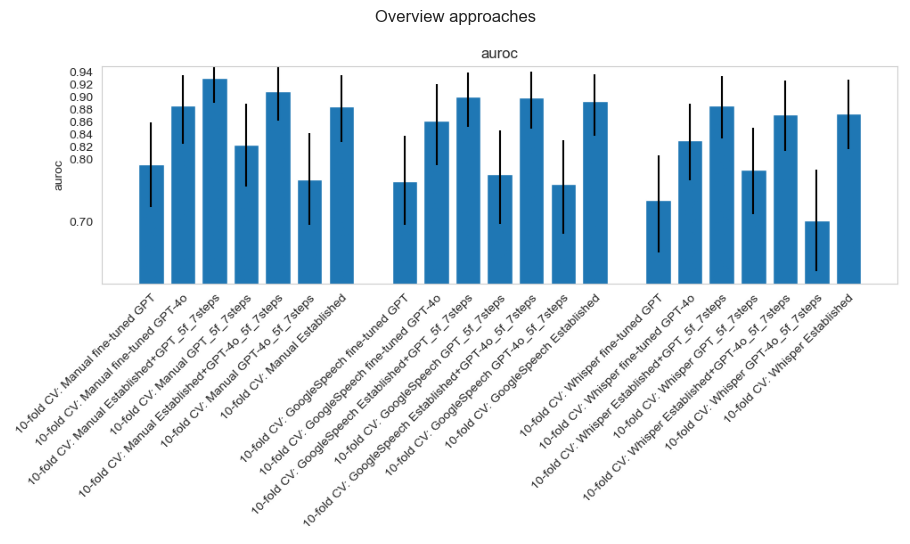

,Approach,auroc,CI
0,10-fold CV: Manual fine-tuned GPT,$0.792$,"$[0.723, 0.859]$"
1,10-fold CV: Manual fine-tuned GPT-4o,$0.886$,"$[0.825, 0.936]$"
2,10-fold CV: Manual Established+GPT_5features,$0.931$,"$[0.891, 0.962]$"
3,10-fold CV: Manual GPT_5features,$0.824$,"$[0.756, 0.890]$"
4,10-fold CV: Manual Established+GPT-4o_5features,$0.910$,"$[0.863, 0.950]$"
5,10-fold CV: Manual GPT-4o_5features,$0.767$,"$[0.695, 0.843]$"
6,10-fold CV: Manual Established,$0.885$,"$[0.828, 0.936]$"
7,,,
8,10-fold CV: GoogleSpeech fine-tuned GPT,$0.765$,"$[0.694, 0.837]$"
9,10-fold CV: GoogleSpeech fine-tuned GPT-4o,$0.862$,"$[0.790, 0.921]$"


\begin{tabular}{lll}
\toprule
Approach & auroc & CI \\
\midrule
10-fold CV: Manual fine-tuned GPT & $0.792$ & $[0.723, 0.859]$ \\
10-fold CV: Manual fine-tuned GPT-4o & $0.886$ & $[0.825, 0.936]$ \\
10-fold CV: Manual Established+GPT_5features & $0.931$ & $[0.891, 0.962]$ \\
10-fold CV: Manual GPT_5features & $0.824$ & $[0.756, 0.890]$ \\
10-fold CV: Manual Established+GPT-4o_5features & $0.910$ & $[0.863, 0.950]$ \\
10-fold CV: Manual GPT-4o_5features & $0.767$ & $[0.695, 0.843]$ \\
10-fold CV: Manual Established & $0.885$ & $[0.828, 0.936]$ \\
 &  &  \\
10-fold CV: GoogleSpeech fine-tuned GPT & $0.765$ & $[0.694, 0.837]$ \\
10-fold CV: GoogleSpeech fine-tuned GPT-4o & $0.862$ & $[0.790, 0.921]$ \\
10-fold CV: GoogleSpeech Established+GPT_5features & $0.900$ & $[0.852, 0.940]$ \\
10-fold CV: GoogleSpeech GPT_5features & $0.776$ & $[0.697, 0.847]$ \\
10-fold CV: GoogleSpeech Established+GPT-4o_5features & $0.899$ & $[0.849, 0.941]$ \\
10-fold CV: GoogleSpeech GPT-4o_5features & $0.760$

In [6]:

def get_metrics_flat_with_ci(metric_name, predictions_flat, labels_flat):
    predictions_rounded = np.round(np.array(predictions_flat))
    tuple_categorical = (labels_flat, predictions_rounded)
    tuple_continuous = (labels_flat, predictions_flat)

    # callable for the metric, and the data to be used
    metrics = {
        'accuracy': (sk_metrics.accuracy_score, tuple_categorical),
        'sensitivity': (sk_metrics.recall_score, tuple_categorical),
        'precision': (sk_metrics.precision_score, tuple_categorical),
        'auroc': (sk_metrics.roc_auc_score, tuple_continuous),
        # average_precision = Area under the PR curve (https://en.wikipedia.org/w/index.php?title=Information_retrieval&oldid=793358396#Average_precision)
        'average_precision': (sk_metrics.average_precision_score, tuple_continuous),
        'log_loss': (sk_metrics.log_loss, tuple_continuous),
        'f1_score': (sk_metrics.f1_score, tuple_categorical),
    }

    statistic_callable, data_tuple = metrics[metric_name]
    estimate = statistic_callable(*data_tuple)
    bootstrap = stats.bootstrap(data_tuple, statistic_callable, n_resamples=1000, vectorized=False, method='percentile', paired=True)
    confidence_interval = bootstrap.confidence_interval
    bootstrap_distribution = bootstrap.bootstrap_distribution

    print(f"{metric_name}: {estimate} [{confidence_interval.low}, {confidence_interval.high}]")

    return estimate, confidence_interval#, bootstrap_distribution

def compare_models(metric_name, labels_a, predictions_a, labels_b, predictions_b, n_bootstrap_samples=1000, confidence_level=0.95, model_name_a="", model_name_b=""):
    
    if not np.all(labels_a == labels_b):
        print(f"labels don't match, cannot compare {model_name_a} vs {model_name_b}")
        return None
    
    data_tuple = (labels_a, predictions_a, labels_b, predictions_b)

    def difference_in_metric(labels_a, predictions_a, labels_b, predictions_b):
        if metric_name == 'auroc':
            res_a = sk_metrics.roc_auc_score(labels_a, predictions_a)
            res_b = sk_metrics.roc_auc_score(labels_b, predictions_b)        
        elif metric_name in ['accuracy', 'precision', 'sensitivity', 'f1_score']:
            # use binary predictions (rounded)
            metric_callable = {'accuracy': sk_metrics.accuracy_score, 'precision': sk_metrics.precision_score, 'sensitivity': sk_metrics.recall_score, 'f1_score': sk_metrics.f1_score}.get(metric_name)
            res_a = metric_callable(labels_a, np.round(predictions_a))
            res_b = metric_callable(labels_b, np.round(predictions_b))
        else:
            raise ValueError(f"Metric {metric_name} not supported")
        return res_a - res_b
    difference_in_auc_res = stats.bootstrap(data_tuple, difference_in_metric, n_resamples=n_bootstrap_samples, vectorized=False, method='percentile', paired=True, confidence_level=confidence_level)
    difference_in_auc_ci = difference_in_auc_res.confidence_interval
    p_value = np.sum(difference_in_auc_res.bootstrap_distribution > 0) / n_bootstrap_samples
    p_value = min(p_value, 1 - p_value)
    
    return {'difference_in_auroc_ci': difference_in_auc_ci, 'pval': p_value}


def plot_results_plots_for_metric(metric_name, predictions, labels, figsize=(10, 5), show=True, group_sizes=()):
    # for one metric (metric_name), plot  results
    
    metric_estimates = []
    bootstrap_confidence_intervals = []

    def sort_key(x):
        x = x.lower()
        data_key = 1 if 'manual' in x else 2
        algo_key = 1 if 'bert' in x else 2
        asr_key = 1 if 'manual' in x else 2 if 'google' in x else 3 if 'whisper' in x else 4
        evaluation_key = 1 if 'adr_test' in x else 2
        custom_key = 1 if 'bert' in x else 2 if 'fine-tuned gpt' in x else 3 if 'gpt_1f' in x else 4 if 'gpt_5f' in x else 5 if 'gpt-4o_5f' in x else 6 if 'established' in x else 6
        #print("sort-key", x, asr_key, evaluation_key, custom_key, data_key, algo_key, asr_key, x)
        return asr_key, evaluation_key, custom_key, data_key, algo_key, asr_key, x
    settings = sorted([parameter_string for parameter_string in predictions], key=sort_key)

    for parameter_string in settings:
        assert len(predictions[parameter_string]) == 1, f"There should only be one result per setting, but there are {len(predictions[parameter_string])} for {parameter_string}"
        metric, bootstrap_ci = get_metrics_flat_with_ci(metric_name, predictions[parameter_string][0], labels[parameter_string][0])
        metric_estimates.append(metric)
        bootstrap_confidence_intervals.append(bootstrap_ci)


    ## BAR PLOT
    bar_heights = metric_estimates
    bar_errors = np.abs(np.array(bootstrap_confidence_intervals).T - np.array(bar_heights))
    
    # check if group_sizes match: the sum of all groups should correspond to the number of bars
    assert len(bar_heights) == np.sum(group_sizes), f"Group sizes do not work. We have {len(bar_heights)} results for group sizes {group_sizes} (total: {np.sum(group_sizes)})"

    # group_sizes = size of the groups in the plot (spaces between)
    space_positions = [sum(group_sizes[:i+1])+i for i in range(len(group_sizes))]

    # the label locations
    x = np.arange(len(settings) + len(space_positions))
    x = np.array([i for i in x if i not in space_positions])

    width = 0.8
    label_offset = 0

    fig, ax = plt.subplots(layout='constrained', figsize=figsize)
    ax.grid(zorder=0)
    rects = ax.bar(x, bar_heights, width, yerr=bar_errors)

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(f'{metric_name}')
    #ax.set_xlabel('Version')
    ax.set_title(f"{metric_name}")
    ax.set_xticks(x + label_offset, [s for s in settings], rotation=45, ha='right', rotation_mode='anchor')
    ax.set_ylim(0.6, 0.95)
    ax.set_yticks(np.array([70,80,82,84,86,88,90,92,94])/100)
    filepath = f"plots/{metric_name.replace(' / ', '_').replace(' ', '_')}_bar.png"
    

    plt.grid()
    plt.savefig(filepath)
    if show:
        plt.show()
    else:
        plt.close()
        


    return filepath, settings, metric_estimates, bootstrap_confidence_intervals


def show_all_metrics_grid(experiment_name, metrics, predictions, labels, figsize_individual=(5,4), group_sizes=()):
    # For each metric in metrics, show a box plot with the results, and write Latex code for the results table

    # calculate individual box plots (and plot ROC curve, if m == 'auroc')
    individual_plots = [(m, plot_results_plots_for_metric(m, predictions, labels, figsize_individual, show=False, group_sizes=group_sizes)) for m in metrics]
    
    # distribution of results for each metric, will be returned from this function, to calculate t-test for significant difference further down
    results_distribution = {}
    
    # initialize figure
    n_cols = int(np.ceil(np.sqrt(len(metrics))))
    n_rows = int(np.ceil(len(metrics) / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*figsize_individual[0], n_rows*figsize_individual[1]))
    if n_rows > 1:
        axes = [item for list in axes for item in list]
    elif n_rows == 1 and n_cols == 1:
        axes = [axes]
    [axis.set_axis_off() for axis in axes]
    [axis.set_xticklabels([]) for axis in axes]
    [axis.set_yticklabels([]) for axis in axes]
    idx = 0
    plt.rcParams["figure.autolayout"] = True

    # load individual box plots and show in grid
    for metric, (path, settings, metric_estimates, bootstrap_confidence_intervals) in sorted(individual_plots):
        img = mpimg.imread(path)
        axes[idx].imshow(img)
        idx += 1
        
    # finalize plot
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle(f"{experiment_name}")
    experiment_name_part = experiment_name.replace(" ", "_").lower()
    plt.tight_layout()
    plt.savefig(f"plots/combined_metrics_{experiment_name_part}.png")
    plt.show()
    
    
    # prepare and print Latex table
    model_metrics = [pd.DataFrame([{'Approach': setting, metric: fr"${estimate:.3f}$", 'CI': f"$[{ci.low:.3f}, {ci.high:.3f}]$"} for setting, estimate, ci in zip(settings, metric_estimates, bootstrap_confidence_intervals)]) for metric, (path, settings, metric_estimates, bootstrap_confidence_intervals) in individual_plots]
    models_table = model_metrics[0]
    for m in model_metrics[1:]:
        models_table = models_table.merge(m, on="Approach", how="outer")
    models_table_sections = []
    i = 0
    for _, size in enumerate(group_sizes):
        section = models_table.iloc[i:i+size, :]
        models_table_sections.append(section)
        if i+size < models_table.shape[0]:
            # add empty row
            models_table_sections.append(pd.DataFrame.from_dict({c: [""] for c in section.columns}, orient='columns'))
        i += size
    models_table_with_spacing = pd.concat(models_table_sections, ignore_index=True)
    display(models_table_with_spacing)
    latex_code = models_table_with_spacing.to_latex(index=False)
    print(latex_code)


    return individual_plots

group_sizes = [7, 7, 0, 7, 7, 0, 7, 7, 0, ]
group_sizes = [7, 7, 7]

individual_plots = show_all_metrics_grid("Overview approaches", [MAIN_METRIC], predictions, labels, figsize_individual=(10,5.5), 
                                             group_sizes=group_sizes)

In [7]:
# explicitly compare certain models
all_settings = [parameter_string for parameter_string in predictions]
models_to_compare = [
    ('Established', 'Established+GPT_5features'),
    ('Established', 'Established+GPT-4o_5features'),
]
#for setup in ['10-fold CV: Manual', '10-fold CV: Whisper', '10-fold CV: GoogleSpeech', 'ADR_test: Manual', 'ADR_test: Whisper', 'ADR_test: GoogleSpeech']:
for setup in ['10-fold CV: Manual', '10-fold CV: Whisper', '10-fold CV: GoogleSpeech']:
    print(f"\n**{setup}**\n")
    for model1, model2 in models_to_compare:
        setting1 = f"{setup} {model1}"
        setting2 = f"{setup} {model2}"
        assert setting1 in predictions, f"{setting1} not available"
        assert setting2 in predictions, f"{setting2} not available"
        statistic_comparison = compare_models(MAIN_METRIC, labels[setting1][0], predictions[setting1][0], labels[setting2][0], predictions[setting2][0], model_name_a=setting1, model_name_b=setting2)
        if statistic_comparison is None:
            continue
        difference_in_auroc_ci = statistic_comparison['difference_in_auroc_ci']
        is_significant = np.sign(difference_in_auroc_ci.low) == np.sign(difference_in_auroc_ci.high)
        print(f"{'SIGNIFICANT' if is_significant else ''} {setting1} vs. {setting2}: ConfInt({difference_in_auroc_ci.low:.3f}, {difference_in_auroc_ci.high:.3f}), pval: {statistic_comparison['pval']}")



**10-fold CV: Manual**

SIGNIFICANT 10-fold CV: Manual Established vs. 10-fold CV: Manual Established+GPT_5features: ConfInt(-0.086, -0.010), pval: 0.006
 10-fold CV: Manual Established vs. 10-fold CV: Manual Established+GPT-4o_5features: ConfInt(-0.066, 0.013), pval: 0.111

**10-fold CV: Whisper**

 10-fold CV: Whisper Established vs. 10-fold CV: Whisper Established+GPT_5features: ConfInt(-0.038, 0.012), pval: 0.173
 10-fold CV: Whisper Established vs. 10-fold CV: Whisper Established+GPT-4o_5features: ConfInt(-0.024, 0.027), pval: 0.46499999999999997

**10-fold CV: GoogleSpeech**

 10-fold CV: GoogleSpeech Established vs. 10-fold CV: GoogleSpeech Established+GPT_5features: ConfInt(-0.044, 0.028), pval: 0.338
 10-fold CV: GoogleSpeech Established vs. 10-fold CV: GoogleSpeech Established+GPT-4o_5features: ConfInt(-0.038, 0.031), pval: 0.392


In [8]:
# prepare and print Latex table
model_metrics = [pd.DataFrame([{'Approach': setting, metric: fr"${estimate:.3f}$ $[{ci.low:.3f}, {ci.high:.3f}]$"} for setting, estimate, ci in zip(settings, metric_estimates, bootstrap_confidence_intervals)]) for metric, (path, settings, metric_estimates, bootstrap_confidence_intervals) in individual_plots]
models_table = model_metrics[0]
for m in model_metrics[1:]:
    models_table = models_table.merge(m, on="Approach", how="outer")
models_table_sections = []
i = 0
for _, size in enumerate(group_sizes):
    section = models_table.iloc[i:i+size, :]
    models_table_sections.append(section)
    if i+size < models_table.shape[0]:
        # add empty row
        models_table_sections.append(pd.DataFrame.from_dict({c: [""] for c in section.columns}, orient='columns'))
    i += size
models_table_with_spacing = pd.concat(models_table_sections, ignore_index=True)
display(models_table_with_spacing)
latex_code = models_table_with_spacing.to_latex(index=False)
print(latex_code)


,Approach,auroc
0,10-fold CV: Manual fine-tuned GPT,"$0.792$ $[0.723, 0.859]$"
1,10-fold CV: Manual fine-tuned GPT-4o,"$0.886$ $[0.825, 0.936]$"
2,10-fold CV: Manual Established+GPT_5features,"$0.931$ $[0.891, 0.962]$"
3,10-fold CV: Manual GPT_5features,"$0.824$ $[0.756, 0.890]$"
4,10-fold CV: Manual Established+GPT-4o_5features,"$0.910$ $[0.863, 0.950]$"
5,10-fold CV: Manual GPT-4o_5features,"$0.767$ $[0.695, 0.843]$"
6,10-fold CV: Manual Established,"$0.885$ $[0.828, 0.936]$"
7,,
8,10-fold CV: GoogleSpeech fine-tuned GPT,"$0.765$ $[0.694, 0.837]$"
9,10-fold CV: GoogleSpeech fine-tuned GPT-4o,"$0.862$ $[0.790, 0.921]$"


\begin{tabular}{ll}
\toprule
Approach & auroc \\
\midrule
10-fold CV: Manual fine-tuned GPT & $0.792$ $[0.723, 0.859]$ \\
10-fold CV: Manual fine-tuned GPT-4o & $0.886$ $[0.825, 0.936]$ \\
10-fold CV: Manual Established+GPT_5features & $0.931$ $[0.891, 0.962]$ \\
10-fold CV: Manual GPT_5features & $0.824$ $[0.756, 0.890]$ \\
10-fold CV: Manual Established+GPT-4o_5features & $0.910$ $[0.863, 0.950]$ \\
10-fold CV: Manual GPT-4o_5features & $0.767$ $[0.695, 0.843]$ \\
10-fold CV: Manual Established & $0.885$ $[0.828, 0.936]$ \\
 &  \\
10-fold CV: GoogleSpeech fine-tuned GPT & $0.765$ $[0.694, 0.837]$ \\
10-fold CV: GoogleSpeech fine-tuned GPT-4o & $0.862$ $[0.790, 0.921]$ \\
10-fold CV: GoogleSpeech Established+GPT_5features & $0.900$ $[0.852, 0.940]$ \\
10-fold CV: GoogleSpeech GPT_5features & $0.776$ $[0.697, 0.847]$ \\
10-fold CV: GoogleSpeech Established+GPT-4o_5features & $0.899$ $[0.849, 0.941]$ \\
10-fold CV: GoogleSpeech GPT-4o_5features & $0.760$ $[0.680, 0.830]$ \\
10-fold CV: 

In [9]:
df = model_metrics[0]
df = df.rename(columns={'Approach': 'approach_raw'})
df['Approach'] = df['approach_raw'].apply(lambda x: re.match("(ADR_test|10-fold CV): (Manual|GoogleSpeech|Whisper)?\s*(.*)", x).group(3))
df['Evaluation'] = df['approach_raw'].apply(lambda x: re.match("(ADR_test|10-fold CV): (.*)", x).group(1))
df['ASR'] = df['approach_raw'].apply(lambda x: re.match("(ADR_test|10-fold CV): (Manual|GoogleSpeech|Whisper)?\s*(.*)", x).group(2))

df

,approach_raw,auroc,Approach,Evaluation,ASR
0,10-fold CV: Manual fine-tuned GPT,"$0.792$ $[0.723, 0.859]$",fine-tuned GPT,10-fold CV,Manual
1,10-fold CV: Manual fine-tuned GPT-4o,"$0.886$ $[0.825, 0.936]$",fine-tuned GPT-4o,10-fold CV,Manual
2,10-fold CV: Manual Established+GPT_5features,"$0.931$ $[0.891, 0.962]$",Established+GPT_5features,10-fold CV,Manual
3,10-fold CV: Manual GPT_5features,"$0.824$ $[0.756, 0.890]$",GPT_5features,10-fold CV,Manual
4,10-fold CV: Manual Established+GPT-4o_5features,"$0.910$ $[0.863, 0.950]$",Established+GPT-4o_5features,10-fold CV,Manual
5,10-fold CV: Manual GPT-4o_5features,"$0.767$ $[0.695, 0.843]$",GPT-4o_5features,10-fold CV,Manual
6,10-fold CV: Manual Established,"$0.885$ $[0.828, 0.936]$",Established,10-fold CV,Manual
7,10-fold CV: GoogleSpeech fine-tuned GPT,"$0.765$ $[0.694, 0.837]$",fine-tuned GPT,10-fold CV,GoogleSpeech
8,10-fold CV: GoogleSpeech fine-tuned GPT-4o,"$0.862$ $[0.790, 0.921]$",fine-tuned GPT-4o,10-fold CV,GoogleSpeech
9,10-fold CV: GoogleSpeech Established+GPT_5feat...,"$0.900$ $[0.852, 0.940]$",Established+GPT_5features,10-fold CV,GoogleSpeech


In [10]:
pivoted = df.pivot(index='Approach', columns=['Evaluation', 'ASR'], values=[MAIN_METRIC])#.reset_index()
pivoted.columns = ["-".join(tpl) for tpl in pivoted.columns]
#pivoted = pivoted[['auroc-10-fold CV-Manual', 'auroc-ADR_test-Manual', 'auroc-10-fold CV-GoogleSpeech', 'auroc-ADR_test-GoogleSpeech', 'auroc-10-fold CV-Whisper', 'auroc-ADR_test-Whisper']]
pivoted = pivoted[[f'{MAIN_METRIC}-10-fold CV-Manual', f'{MAIN_METRIC}-10-fold CV-GoogleSpeech', f'{MAIN_METRIC}-10-fold CV-Whisper']]
pivoted = pivoted.map(lambda x: x.replace("$ $[", "$ ${\scriptstyle [").replace("]$", "] }$")) 

pivoted

,auroc-10-fold CV-Manual,auroc-10-fold CV-GoogleSpeech,auroc-10-fold CV-Whisper
Approach,,,
Established,"$0.885$ ${\scriptstyle [0.828, 0.936] }$","$0.893$ ${\scriptstyle [0.837, 0.937] }$","$0.874$ ${\scriptstyle [0.816, 0.927] }$"
Established+GPT-4o_5features,"$0.910$ ${\scriptstyle [0.863, 0.950] }$","$0.899$ ${\scriptstyle [0.849, 0.941] }$","$0.872$ ${\scriptstyle [0.814, 0.926] }$"
Established+GPT_5features,"$0.931$ ${\scriptstyle [0.891, 0.962] }$","$0.900$ ${\scriptstyle [0.852, 0.940] }$","$0.886$ ${\scriptstyle [0.834, 0.934] }$"
GPT-4o_5features,"$0.767$ ${\scriptstyle [0.695, 0.843] }$","$0.760$ ${\scriptstyle [0.680, 0.830] }$","$0.702$ ${\scriptstyle [0.620, 0.783] }$"
GPT_5features,"$0.824$ ${\scriptstyle [0.756, 0.890] }$","$0.776$ ${\scriptstyle [0.697, 0.847] }$","$0.784$ ${\scriptstyle [0.711, 0.851] }$"
fine-tuned GPT,"$0.792$ ${\scriptstyle [0.723, 0.859] }$","$0.765$ ${\scriptstyle [0.694, 0.837] }$","$0.735$ ${\scriptstyle [0.650, 0.806] }$"
fine-tuned GPT-4o,"$0.886$ ${\scriptstyle [0.825, 0.936] }$","$0.862$ ${\scriptstyle [0.790, 0.921] }$","$0.831$ ${\scriptstyle [0.766, 0.890] }$"


In [11]:
print(pivoted.to_latex())

\begin{tabular}{llll}
\toprule
 & auroc-10-fold CV-Manual & auroc-10-fold CV-GoogleSpeech & auroc-10-fold CV-Whisper \\
Approach &  &  &  \\
\midrule
Established & $0.885$ ${\scriptstyle [0.828, 0.936] }$ & $0.893$ ${\scriptstyle [0.837, 0.937] }$ & $0.874$ ${\scriptstyle [0.816, 0.927] }$ \\
Established+GPT-4o_5features & $0.910$ ${\scriptstyle [0.863, 0.950] }$ & $0.899$ ${\scriptstyle [0.849, 0.941] }$ & $0.872$ ${\scriptstyle [0.814, 0.926] }$ \\
Established+GPT_5features & $0.931$ ${\scriptstyle [0.891, 0.962] }$ & $0.900$ ${\scriptstyle [0.852, 0.940] }$ & $0.886$ ${\scriptstyle [0.834, 0.934] }$ \\
GPT-4o_5features & $0.767$ ${\scriptstyle [0.695, 0.843] }$ & $0.760$ ${\scriptstyle [0.680, 0.830] }$ & $0.702$ ${\scriptstyle [0.620, 0.783] }$ \\
GPT_5features & $0.824$ ${\scriptstyle [0.756, 0.890] }$ & $0.776$ ${\scriptstyle [0.697, 0.847] }$ & $0.784$ ${\scriptstyle [0.711, 0.851] }$ \\
fine-tuned GPT & $0.792$ ${\scriptstyle [0.723, 0.859] }$ & $0.765$ ${\scriptstyle [0.694, 0